## Import Necessary package

In [3]:
!pip install geopandas
!git clone https://github.com/gboeing/osmnx.git
!pip install geoparquet

Cloning into 'osmnx'...


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx
import osmnx as ox
import pyarrow.parquet as pq
import geopandas as gpd
import shapely as sh
import requests
import os

## Read SG car data

In [0]:
# download dataset from google drive
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    


def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [0]:
url_sg = "https://drive.google.com/open?id=1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i"
file_id = '1NVglfRzNxXI5VZ-HSxqAQWIxicrUFa1i'
destinationSG = '/content/grab-posis-city=Singapore.zip'

In [0]:
download_file_from_google_drive(file_id, destinationSG)

In [0]:
import zipfile
directorySG = destinationSG

In [0]:
zip_ref = zipfile.ZipFile(directorySG, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [0]:
dataset_SG = pq.ParquetDataset('/tmp/city=Singapore')

In [0]:
dataset_SG = dataset_SG.read()

In [0]:
dataset_SG = dataset_SG.to_pandas()

# SG dataset preprocess

In [0]:
dataset_SG['pingtimestamp'] = pd.to_datetime(dataset_SG['pingtimestamp'], unit='s')
SG_car = dataset_SG.drop(columns=['driving_mode'])
del dataset_SG

In [0]:
SG_car.info()
SG_car['trj_id'] = SG_car['trj_id'].astype('int')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30329685 entries, 0 to 30329684
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   trj_id         object        
 1   osname         object        
 2   pingtimestamp  datetime64[ns]
 3   rawlat         float64       
 4   rawlng         float64       
 5   speed          float64       
 6   bearing        int64         
 7   accuracy       float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.8+ GB


In [0]:
SG_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30329685 entries, 0 to 30329684
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   trj_id         int64         
 1   osname         object        
 2   pingtimestamp  datetime64[ns]
 3   rawlat         float64       
 4   rawlng         float64       
 5   speed          float64       
 6   bearing        int64         
 7   accuracy       float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 1.8+ GB


In [0]:
SG_car.head()

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
0,70014,android,2019-04-11 00:40:36,1.342326,103.888969,18.910000,248,3.9
1,73573,android,2019-04-18 10:17:03,1.321781,103.856366,17.719076,44,4.0
2,75567,android,2019-04-13 07:37:06,1.327088,103.861273,14.021548,34,3.9
3,1410,android,2019-04-20 03:41:33,1.262482,103.823794,13.026521,181,4.0
4,4354,android,2019-04-18 10:48:17,1.283799,103.807210,14.812943,93,3.9


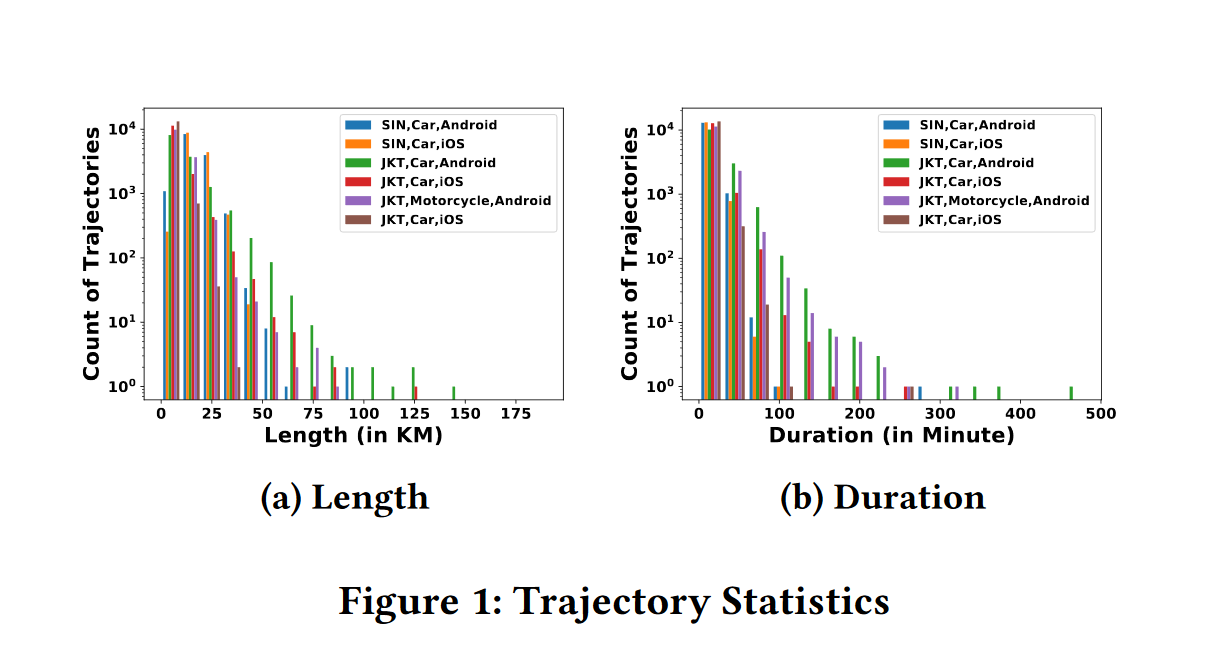

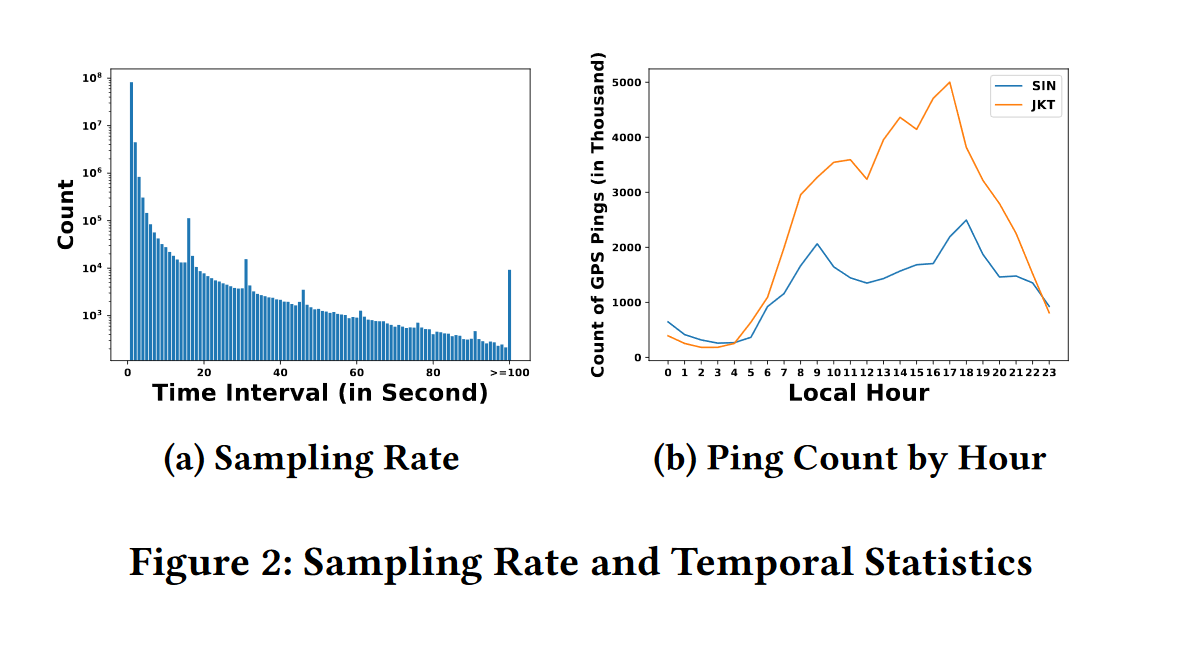

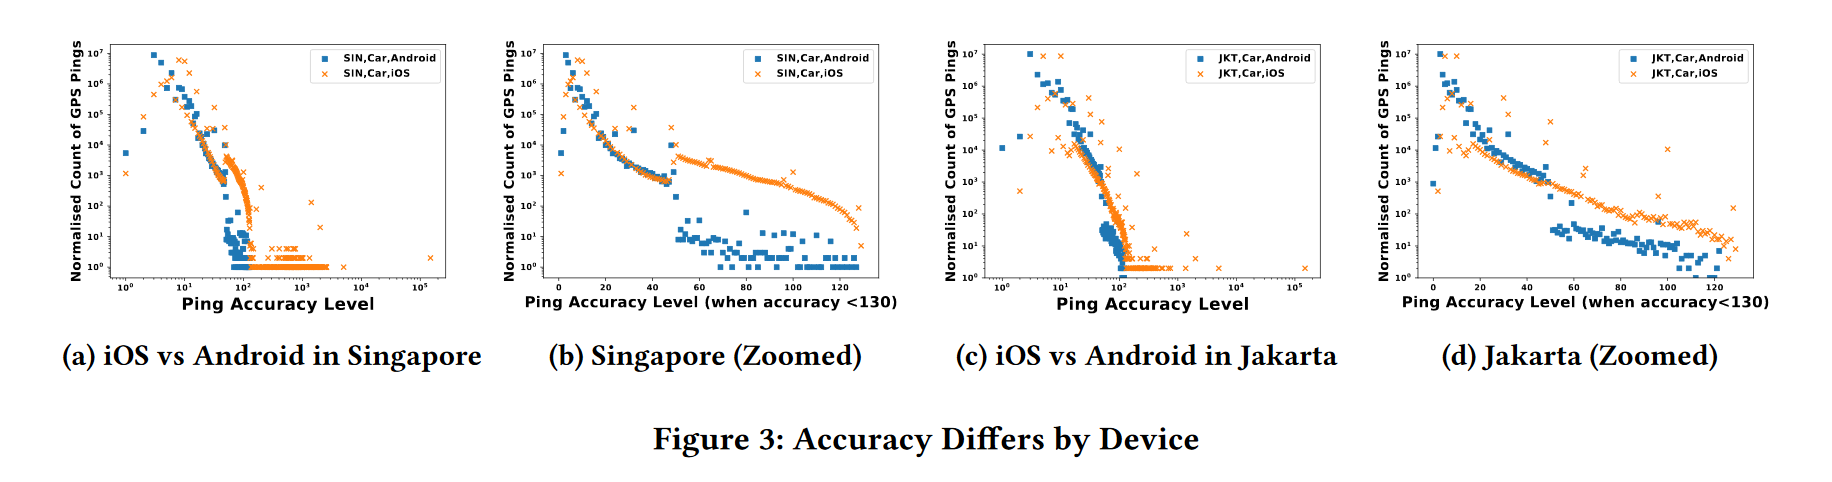

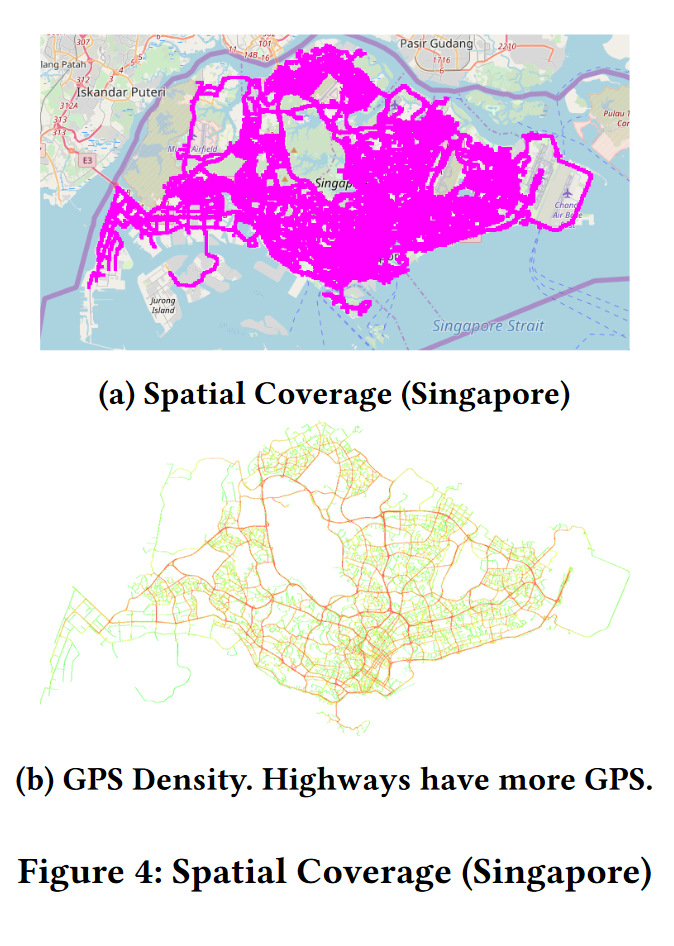

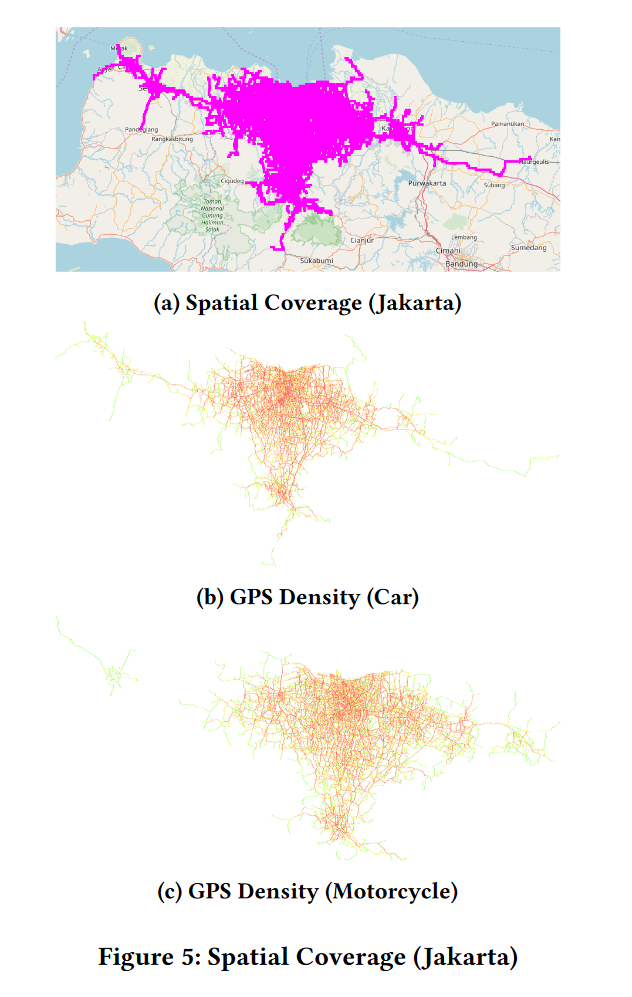

In [0]:
SG_car = SG_car.sort_values(by=['trj_id', 'pingtimestamp'])

### Create Copy of SG car with dataset 
this copy of dataset wll be SG_car_aug, which only contain unique trj_id and also contain the drop off and pickup location, drop off and pickup time, sin and cos of drop off and pickup hour + day

In [0]:
SG_car.head()

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
10332542,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.0
1766918,2,android,2019-04-09 02:38:49,1.270338,103.858102,25.457024,97,32.0
19338567,2,android,2019-04-09 02:38:50,1.270311,103.858331,25.561169,93,32.0
1766774,2,android,2019-04-09 02:38:51,1.270296,103.858560,25.458790,93,32.0
3860091,2,android,2019-04-09 02:38:52,1.270282,103.858786,25.312450,87,32.0


In [0]:
SG_car_aug = SG_car.copy()

In [0]:
SG_car_aug

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy
10332542,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.0
1766918,2,android,2019-04-09 02:38:49,1.270338,103.858102,25.457024,97,32.0
19338567,2,android,2019-04-09 02:38:50,1.270311,103.858331,25.561169,93,32.0
1766774,2,android,2019-04-09 02:38:51,1.270296,103.858560,25.458790,93,32.0
3860091,2,android,2019-04-09 02:38:52,1.270282,103.858786,25.312450,87,32.0
...,...,...,...,...,...,...,...,...
10900430,84000,android,2019-04-18 12:52:41,1.287496,103.845757,8.407369,296,3.9
17261078,84000,android,2019-04-18 12:52:42,1.287538,103.845686,9.100465,300,3.9
27616691,84000,android,2019-04-18 12:52:43,1.287584,103.845613,9.546059,301,3.9
25543931,84000,android,2019-04-18 12:52:44,1.287630,103.845540,9.507404,303,4.0


## Add pick up and drop off information
this include:
- pickup_time
- dropoff_time
- travel_time
- rawlat_pickup
- rawlat_dropoff
- rawlon_pickup
- rawlon_dropoff

In [0]:
# get the travel time by substracting difference in first pingtimestamp with the last pingtimestamp for each trajectory ID
SG_car_aug['travel_time'] = SG_car_aug.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max() - x.min()).astype('timedelta64[s]')

In [0]:
SG_car_aug['pickup_time'] = SG_car_aug.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.min())

In [0]:
SG_car_aug['dropoff_time'] = SG_car_aug.groupby(['trj_id']).pingtimestamp.transform(lambda x: x.max())

In [0]:
# collect garbage, run when RAM is almost full or just need to clear up RAM
import gc
gc.collect()

0

In [0]:
def extractCoordinateAndUpdateDF(df, variable_name, timestamp_col, coordinate_component):
  coord_series = df.groupby(['trj_id']).apply(lambda x: x[x['pingtimestamp'] == x[timestamp_col]][coordinate_component])
  coord_series = coord_series.reset_index().set_index('level_1')
  df_update = df.merge(coord_series, how='left', left_on='trj_id', right_on='trj_id', suffixes=['', '_{}'.format(variable_name)])
  return df_update

In [0]:
# create and merge pickup latitude into SG_car_aug
SG_car_aug = extractCoordinateAndUpdateDF(SG_car_aug, 'pickup', 'pickup_time', 'rawlat')

In [0]:
# create and merge pickup longitude into SG_car_aug
SG_car_aug = extractCoordinateAndUpdateDF(SG_car_aug, 'pickup', 'pickup_time', 'rawlng')

In [0]:
# add drop off latitude
SG_car_aug = extractCoordinateAndUpdateDF(SG_car_aug, 'dropoff', 'dropoff_time', 'rawlat')

In [0]:
# add drop off longitude
SG_car_aug = extractCoordinateAndUpdateDF(SG_car_aug, 'dropoff', 'dropoff_time', 'rawlng')

In [0]:
SG_car_aug

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
1,2,android,2019-04-09 02:38:49,1.270338,103.858102,25.457024,97,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
2,2,android,2019-04-09 02:38:50,1.270311,103.858331,25.561169,93,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
3,2,android,2019-04-09 02:38:51,1.270296,103.858560,25.458790,93,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
4,2,android,2019-04-09 02:38:52,1.270282,103.858786,25.312450,87,32.0,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30329680,84000,android,2019-04-18 12:52:41,1.287496,103.845757,8.407369,296,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329681,84000,android,2019-04-18 12:52:42,1.287538,103.845686,9.100465,300,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329682,84000,android,2019-04-18 12:52:43,1.287584,103.845613,9.546059,301,3.9,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468
30329683,84000,android,2019-04-18 12:52:44,1.287630,103.845540,9.507404,303,4.0,1475.0,2019-04-18 12:28:10,2019-04-18 12:52:45,1.346787,103.984266,1.287678,103.845468


# Preprocess hour and day to cyclical data
we will use sin and cos function to model the time and day into a continuos cyclical cycle.

In [0]:
SG_car_aug_colapse = SG_car_aug.drop_duplicates(subset=['trj_id', 'pickup_time'], keep='first')

In [0]:
SG_car_aug_colapse = SG_car_aug_colapse.reset_index().drop(columns=['index'])

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354
1,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278
2,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504
3,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220
4,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496
27996,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737
27997,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843
27998,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728


In [0]:
# check if our trj_id row ping is the same as pickup time 
(SG_car_aug_colapse['pingtimestamp'] == SG_car_aug_colapse['pickup_time']).sum()

28000

In [0]:
SG_car_aug_colapse.columns

Index(['trj_id', 'osname', 'pingtimestamp', 'rawlat', 'rawlng', 'speed',
       'bearing', 'accuracy', 'travel_time', 'pickup_time', 'dropoff_time',
       'rawlat_pickup', 'rawlng_pickup', 'rawlat_dropoff', 'rawlng_dropoff'],
      dtype='object')

In [0]:
# add pickup_hour and pickup_day column
SG_car_aug_colapse['pickup_hour'] = SG_car_aug_colapse['pickup_time'].dt.hour
SG_car_aug_colapse['pickup_day'] = SG_car_aug_colapse['pickup_time'].dt.dayofweek

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1
1,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4
2,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5
3,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5
4,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0
27996,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1
27997,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6
27998,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2


(3875.0, 4116.0)

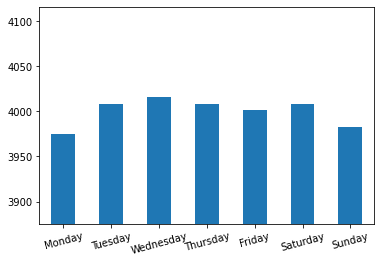

In [0]:
# visualize the distribution of ride by day
number_of_rides_by_day = SG_car_aug_colapse.groupby('pickup_day')['trj_id'].count()
number_of_rides_by_day.index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
number_of_rides_by_day.plot.bar(y='trj_id', rot=15)
plt.ylim(number_of_rides_by_day.min()-100, number_of_rides_by_day.max()+100)

(113.0, 2204.0)

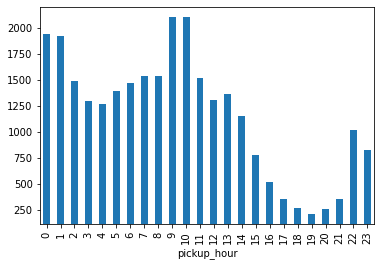

In [0]:
# visualize the distribution of ride by hours
number_of_rides_by_hour = SG_car_aug_colapse.groupby('pickup_hour')['trj_id'].count()
number_of_rides_by_hour.plot.bar(y='trj_id')
plt.ylim(number_of_rides_by_hour.min()-100, number_of_rides_by_hour.max()+100)

In [0]:
# lets visualize the day by continuous date instead

#first, we need to downsample the pickuptime to by day and by hour
SG_downsampled = SG_car_aug_colapse[['trj_id', 'pickup_time']]
SG_day_downsampled = SG_downsampled.set_index('pickup_time').sort_index()
SG_day_downsampled

,trj_id
pickup_time,
2019-04-08 00:09:26,70895
2019-04-08 00:09:48,21926
2019-04-08 00:09:50,47498
2019-04-08 00:09:55,18103
2019-04-08 00:09:57,41322
...,...
2019-04-21 23:30:57,44505
2019-04-21 23:31:30,5652
2019-04-21 23:33:04,32449


## Downsample data by day

In [0]:
# Downsampled the data by day
SG_day_downsampled =SG_day_downsampled.resample('D').count()
SG_day_downsampled

,trj_id
pickup_time,
2019-04-08,1976
2019-04-09,2004
2019-04-10,2004
2019-04-11,2000
2019-04-12,2007
2019-04-13,2004
2019-04-14,1980
2019-04-15,1999
2019-04-16,2004


In [0]:
SG_day_downsampled['pickup_day'] = SG_day_downsampled.index.to_series().dt.dayofweek
SG_day_downsampled

,trj_id,pickup_day
pickup_time,,
2019-04-08,1976,0
2019-04-09,2004,1
2019-04-10,2004,2
2019-04-11,2000,3
2019-04-12,2007,4
2019-04-13,2004,5
2019-04-14,1980,6
2019-04-15,1999,0
2019-04-16,2004,1


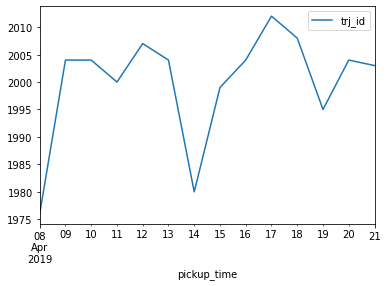

In [0]:
# the distribution of rides by day seems to follow the trends that
# sunday have less ride and any other day have more people take a ride.
# this may be caused by work commuting
# 2019-04-19 is the exception since its a "Good Friday" and a holiday where peole don't go to school or work
# while 2019-04-21 is easter day. this may be caused of the surge in rides.
# unfortunately we only have 2 weeks worth of data, so we can't see clearly the 
# pattern of time sensitive data.
# but normally, if we have a long enough data, it will follow a similar distribution for weekly ride counts.
# we will see this clearly in the number of rides distribution by daily 24 hours.
SG_day_downsampled.plot(y='trj_id', use_index=True)

In [0]:
SG_day_downsampled['sin_time'] = np.sin(2*np.pi*SG_day_downsampled.pickup_day/7)
SG_day_downsampled['cos_time'] = np.cos(2*np.pi*SG_day_downsampled.pickup_day/7)
SG_day_downsampled

,trj_id,pickup_day,sin_time,cos_time
pickup_time,,,,
2019-04-08,1976,0,0.000000,1.000000
2019-04-09,2004,1,0.781831,0.623490
2019-04-10,2004,2,0.974928,-0.222521
2019-04-11,2000,3,0.433884,-0.900969
2019-04-12,2007,4,-0.433884,-0.900969
2019-04-13,2004,5,-0.974928,-0.222521
2019-04-14,1980,6,-0.781831,0.623490
2019-04-15,1999,0,0.000000,1.000000
2019-04-16,2004,1,0.781831,0.623490


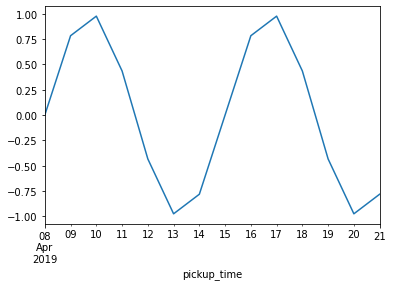

In [0]:
SG_day_downsampled.sin_time.plot()

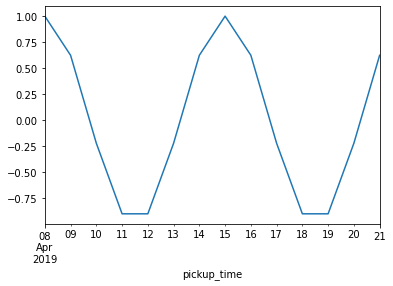

In [0]:
SG_day_downsampled.cos_time.plot()

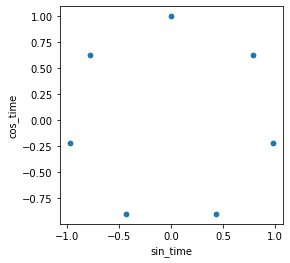

In [0]:
SG_day_downsampled.plot.scatter('sin_time', 'cos_time').set_aspect('equal')

## Downsample data by hour

In [0]:
# lets resample the data by hours now
# Downsampled the data by hours in day
SG_hour_downsampled = SG_downsampled.set_index('pickup_time').sort_index()
SG_hour_downsampled = SG_hour_downsampled.resample('H').count()
SG_hour_downsampled['pickup_hour'] = SG_hour_downsampled.index.to_series().dt.hour
SG_hour_downsampled

,trj_id,pickup_hour
pickup_time,,
2019-04-08 00:00:00,170,0
2019-04-08 01:00:00,155,1
2019-04-08 02:00:00,104,2
2019-04-08 03:00:00,83,3
2019-04-08 04:00:00,67,4
...,...,...
2019-04-21 19:00:00,24,19
2019-04-21 20:00:00,24,20
2019-04-21 21:00:00,45,21


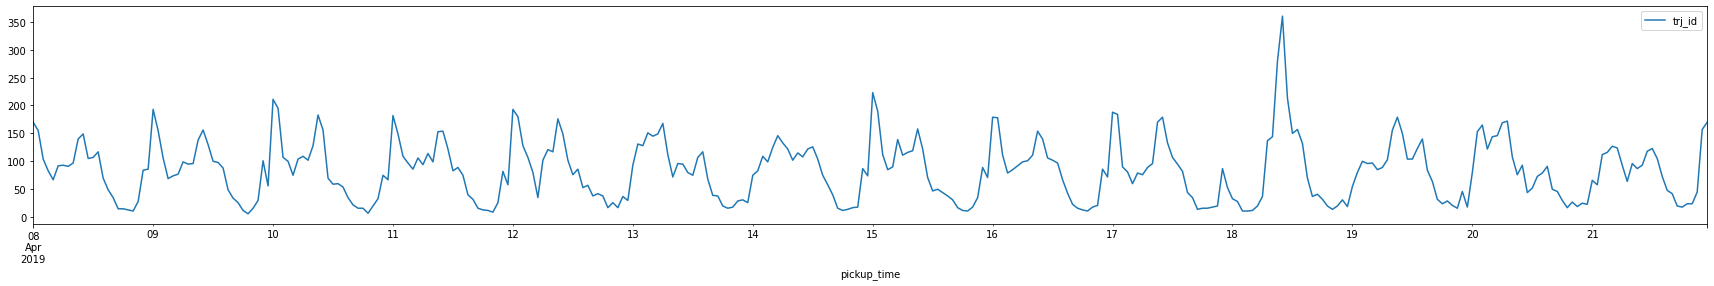

In [0]:
# as we can see here, the distribution of daily number of rides follow closely a similar distribution for each day.
# this data is inherently cyclical as we can see below that for each day, distribution of rides count follow a similar trends when plot by 24 hours point.
# hence we want to encode our time data to also a cyclical data, we can do this with sin and cos of the time
SG_hour_downsampled.plot(y='trj_id', use_index=True, figsize=(30,4))

In [0]:
SG_hour_downsampled['sin_time'] = np.sin(2*np.pi*SG_hour_downsampled.pickup_hour/24)
SG_hour_downsampled['cos_time'] = np.cos(2*np.pi*SG_hour_downsampled.pickup_hour/24)
SG_hour_downsampled

,trj_id,pickup_hour,sin_time,cos_time
pickup_time,,,,
2019-04-08 00:00:00,170,0,0.000000,1.000000
2019-04-08 01:00:00,155,1,0.258819,0.965926
2019-04-08 02:00:00,104,2,0.500000,0.866025
2019-04-08 03:00:00,83,3,0.707107,0.707107
2019-04-08 04:00:00,67,4,0.866025,0.500000
...,...,...,...,...
2019-04-21 19:00:00,24,19,-0.965926,0.258819
2019-04-21 20:00:00,24,20,-0.866025,0.500000
2019-04-21 21:00:00,45,21,-0.707107,0.707107


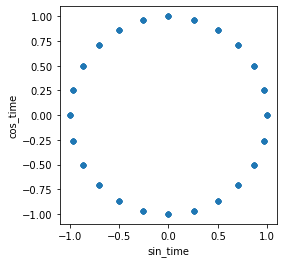

In [0]:
# the graph below shows the cyclical nature of sin and cos of time in 24 hours
SG_hour_downsampled.plot.scatter('sin_time','cos_time').set_aspect('equal');

## Add Sin and cos of time
the features that we will add are as follows:
- sin_pickup_hour
- cos_pickup_hour
- sin_pickup_day
- cos_pickup_day

In [0]:
SG_car_aug_colapse['sin_pickup_hour'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['cos_pickup_hour'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_hour/24)
SG_car_aug_colapse['sin_pickup_day'] = np.sin(2*np.pi*SG_car_aug_colapse.pickup_day/7)
SG_car_aug_colapse['cos_pickup_day'] = np.cos(2*np.pi*SG_car_aug_colapse.pickup_day/7)

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
3,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
27996,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
27997,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
27998,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521


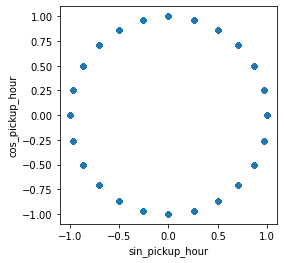

In [0]:
# plot the sin v cos graph of hour
SG_car_aug_colapse.plot.scatter('sin_pickup_hour','cos_pickup_hour').set_aspect('equal');

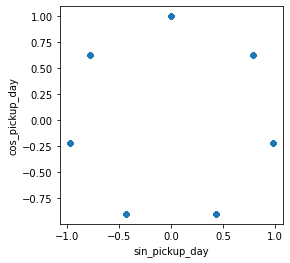

In [0]:
# plot the sin v cos graph of day
SG_car_aug_colapse.plot.scatter('sin_pickup_day','cos_pickup_day').set_aspect('equal');

In [0]:
SG_car_aug_colapse[(SG_car_aug_colapse['speed'] == 0) & (SG_car_aug_colapse['pingtimestamp'] == SG_car_aug_colapse['dropoff_time']) & (SG_car_aug_colapse['osname'] == 'android')]

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day


In [0]:
SG_car_aug.osname.unique()

array(['android', 'ios'], dtype=object)

In [0]:
SG_car_aug_colapse.to_csv("sgcar_colapse.csv")

In [0]:
SG_car_aug_colapse

,trj_id,osname,pingtimestamp,rawlat,rawlng,speed,bearing,accuracy,travel_time,pickup_time,dropoff_time,rawlat_pickup,rawlng_pickup,rawlat_dropoff,rawlng_dropoff,pickup_hour,pickup_day,sin_pickup_hour,cos_pickup_hour,sin_pickup_day,cos_pickup_day
0,2,android,2019-04-09 02:38:48,1.270377,103.857875,25.623161,100,32.000,1520.0,2019-04-09 02:38:48,2019-04-09 03:04:08,1.270377,103.857875,1.446609,103.806354,2,1,5.000000e-01,0.866025,0.781831,0.623490
1,3,ios,2019-04-12 08:32:16,1.282591,103.851082,0.000000,96,30.000,1158.0,2019-04-12 08:32:16,2019-04-12 08:51:34,1.282591,103.851082,1.332855,103.977278,8,4,8.660254e-01,-0.500000,-0.433884,-0.900969
2,4,android,2019-04-13 10:42:40,1.355363,103.863157,5.960000,217,3.900,1366.0,2019-04-13 10:42:40,2019-04-13 11:05:26,1.355363,103.863157,1.343218,103.858504,10,5,5.000000e-01,-0.866025,-0.974928,-0.222521
3,5,ios,2019-04-20 01:39:08,1.340301,103.775742,4.760463,91,6.000,1328.0,2019-04-20 01:39:08,2019-04-20 02:01:16,1.340301,103.775742,1.303071,103.900220,1,5,2.588190e-01,0.965926,-0.974928,-0.222521
4,8,android,2019-04-11 07:24:34,1.333936,103.953225,15.250000,318,4.288,1210.0,2019-04-11 07:24:34,2019-04-11 07:44:44,1.333936,103.953225,1.309601,103.833983,7,3,9.659258e-01,-0.258819,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,83955,android,2019-04-08 22:27:51,1.396872,103.747718,11.609461,191,3.900,1112.0,2019-04-08 22:27:51,2019-04-08 22:46:23,1.396872,103.747718,1.319548,103.843496,22,0,-5.000000e-01,0.866025,0.000000,1.000000
27996,83956,ios,2019-04-09 22:09:13,1.396533,103.747537,3.212061,196,6.000,983.0,2019-04-09 22:09:13,2019-04-09 22:25:36,1.396533,103.747537,1.322236,103.841737,22,1,-5.000000e-01,0.866025,0.781831,0.623490
27997,83957,android,2019-04-21 01:20:41,1.301317,103.899443,11.049027,244,5.600,1382.0,2019-04-21 01:20:41,2019-04-21 01:43:43,1.301317,103.899443,1.410657,103.778843,1,6,2.588190e-01,0.965926,-0.781831,0.623490
27998,83999,android,2019-04-17 11:22:25,1.298612,103.853801,0.000000,0,4.137,1212.0,2019-04-17 11:22:25,2019-04-17 11:42:37,1.298612,103.853801,1.341311,103.981728,11,2,2.588190e-01,-0.965926,0.974928,-0.222521
